In [12]:
# Group : Bohdan Babii, Felix Kreß

# Exercise 1 - Linear Regression

The first exercise is about linear models.
The given data set contains prices and other attributes of approximately 54,000 diamonds. You should fit a linear model to predict the price of a diamond, given its attributes.

This exercise is meant to get you started with the tool stack. Besides numpy and matplotlib we use the following python packages:

- [pandas](https://pandas.pydata.org/)
- [sklearn](http://scikit-learn.org/)

If you are unfamiliar with them, follow the documentation links. 

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de
- maurice.wenig@uni-jena.de

### Submission
- Deadline of submission:
16.04.2024 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=54249)


### Help
In case you cannot solve a task, you can use the saved values within the `help` directory:
- Load arrays with [Numpy](https://numpy.org/doc/stable/reference/generated/numpy.load.html)
```
np.load('help/array_name.npy')
```
- Load functions with [Dill](https://dill.readthedocs.io/en/latest/dill.html)
```
import dill
with open('help/some_func.pkl', 'rb') as f:
    func = dill.load(f)
```

to continue working on the other tasks.

## Preprocessing

We use the same notation as in the lecture.
- $m$... Number of datapoints
- $n$... Number of features

### Dataset 

As a dataset, we use the [diamond dataset](https://www.kaggle.com/shivam2503/diamonds).

Each element in this dataset represents a diamond and has the following features:

- price: price in US dollars (326.0 - 18823.0)
- carat: weight of the diamond (0.2 - 5.01)
- cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: diamond colour, from J (worst) to D (best)
- clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x: length in mm (0-10.74)
- y: width in mm (0-58.9)
- z: depth in mm (0-31.8)
- depth: total depth percentage = 2 * z / (x + y) (43-79)
- table: width of top of diamond relative to widest point (43-95)

The dataset is stored under `diamonds.csv`.

### Task 1
Import the data from the file using [pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) and examine it.

Determine the following:

* The number of data points
* The column names
* The data types for each column

In [1]:
import pandas as pd


# TODO: load data (df = dataframe)
df = pd.read_csv('diamonds.csv')

# TODO: determine number of datapoints
m = len(df)

# TODO: determine column names
column_names = df.columns.tolist()

# TODO: determine datatypes of columns
data_types = df.dtypes

# assertions
assert m == 53940
assert set(column_names) == {"carat", "cut", "color", "clarity", "depth", "table", "price", "x", "y", "z"}
assert data_types["carat"] == "float64"
assert data_types["cut"] == "object"
assert data_types["price"] == "int64"

### Task 2

Since there are discrete variables and we do not yet know how to include them into our regression model, remove them. Additionally, verify that there are no missing values in our dataset.

Hint: there are multiple ways to [check](https://towardsdatascience.com/how-to-check-for-missing-values-in-pandas-d2749e45a345) for missing values

In [2]:
import numpy as np

# TODO: remove discrete variables + check for missing values

any_missing_values = df.isnull().values.any()
df = df.drop(['cut', 'color', 'clarity'], axis=1)


# assertions
assert len(df.columns.values) == 7
assert not any_missing_values

As discussed in the lecture, we should **standardize** the data, to make different scales comparable.

Standardization is defined for each feature $x_i$:

\begin{align}
\hat{x}_i = \cfrac{x_i-\mu_x}{\sigma_x}\,,
\end{align}
where $\mu_x$ and $\sigma_x$ are the empirical [mean](https://en.wikipedia.org/wiki/Mean) and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation) of the feature $x$.

### Task 3

Convert the pandas dataframe to a numpy array and calculate the standardized data matrix $X$.

In [3]:
# TODO: calculate standardized data matrix X
mean = df.mean()
std = df.std()

standardized_df = (df - mean) / std
x = standardized_df.to_numpy()
# assertions
assert  x.shape == (53940, 7)
assert np.allclose(np.mean(x, axis=0), 0)
assert np.allclose(np.std(x, axis=0), 1)

### Task 4

Scikit learn has an [implementation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) of this preprocessing.

Use it to create a second standardized data matrix and compare this result with your result from Task 3.

In [4]:
from sklearn.preprocessing import StandardScaler
# TODO: compare to sklearn result
scaler = StandardScaler()
data = df.to_numpy()
x_sklearn = scaler.fit_transform(data)
# assertions
assert np.allclose(x, x_sklearn)

## Inspecting the Data

Visualizing correlation in your data often helps to build intuition and get a feeling of the deeper mojo in the set.

Here we want to use the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) as a measure for correlation between two variables.

Let $x$ and $y$ be two variables of the unstandardized dataset (e.g. `carat` and `price`). The empirical Pearson correlation coefficient between $x$ and $y$ is defined as 

\begin{align}
r_{xy} = \cfrac{\sum_{i=1}^m (x_i-\bar{x}) (y_i-\bar{y})}{\sqrt{\sum_{i=1}^m(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^m(y_i-\bar{y})^2}}\,,
\end{align}
where $\bar{x}$ and $\bar{y}$ are the respective empirical means.

### Task 5

How does this definition translate to our standardized data matrix $X$?

Calculate the pairwise correlation matrix for our dataset. 

Visualize this correlation matrix and label the rows/columns.

In [5]:
# TODO: calculate correlation matrix
correlations = np.corrcoef(x, rowvar=False)

# assertions
row_0 = np.array([1., 0.02822431, 0.18161755, 0.9215913, 0.97509423, 0.9517222, 0.95338738])
assert np.allclose(correlations[0], row_0)

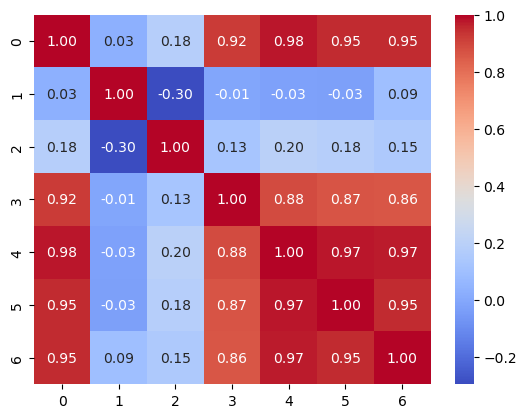

In [6]:
# TODO: Visualize correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

## Linear Regression

Our goal in this exercise will be to predict the `price` of a diamond based on some of its other features.

We will use linear regression, that is we assume the `price` (=$y$) depends linearly on the other features (=$\mathbf{x}$):
\begin{align}
y = \theta^T \mathbf{x} + \varepsilon
\end{align}
where $\varepsilon$ is standard normal distributed noise.

In `Linear_Regression_Script.pdf` you find how the maximum likelihood estimate $\hat\theta$ is calculated.

### Task 6

Implement a `LinReg` class that uses maximum likelihood estimation. Add the possibility to use [Ridge Regression](https://en.wikipedia.org/wiki/Ridge_regression).

In [7]:
from typing import Self
import numpy.typing as npt


class LinearRegressor():
    def __init__(self, regularization_constant: int = 0):
        """Class for linear regression.

        Parameters
        ----------
        regularization_constant : int, optional
            Regularization constant, by default 0.
        """

        self.regularization_constant = regularization_constant
        self.theta: npt.NDArray[np.float64] = None
        
    def fit_max_liklihood(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.float64]) -> Self:
        """Learns the parameters for a linear regression task.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            n_dim x n_data design matrix.
        y : npt.NDArray[np.float64]
            vector of length n_data.
        """

        # TODO: estimate theta
        self.theta = np.linalg.inv(x.T @ x) @ x.T @ y
        return self

    def fit_ridge_regression(self, x: npt.NDArray[np.float64], y: npt.NDArray[np.float64]) -> Self:
        """Learns the parameters for a linear regression task.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            n_dim x n_data design matrix.
        y : npt.NDArray[np.float64]
            vector of length n_data.
        """

        # TODO: estimate theta
        n_data, n_features = x.shape
        I = np.eye(n_data)
        lambda_I = self.regularization_constant * I
        self.theta = np.linalg.inv(x @ x.T + lambda_I) @ x @ y
        return self

    def predict(self, x: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
        """Using learned parameters, predicts output for given X.

        Parameters
        ----------
        x : npt.NDArray[np.float64]
            n_dim x n_data matrix.

        Returns
        -------
        npt.NDArray[np.float64]
            n_data vector of predicted values.
        """

        # TODO: predict labels
        return x @ self.theta


# assertions
np.random.seed(0)
design_matrix = np.random.rand(2,100)
y = np.random.rand(100)
regressor = LinearRegressor(regularization_constant=0.1).fit_ridge_regression(design_matrix, y)
assert np.allclose(regressor.theta, np.array([0.43078951, 0.43061373]))

### Task 7

First we want to predict the `price` of a diamond solely from the variable `carat`. 
Make a scatter plot of `carat` vs `price` using matplotlib. Label the axes and give the plot a title.

Use the standardized dataset.

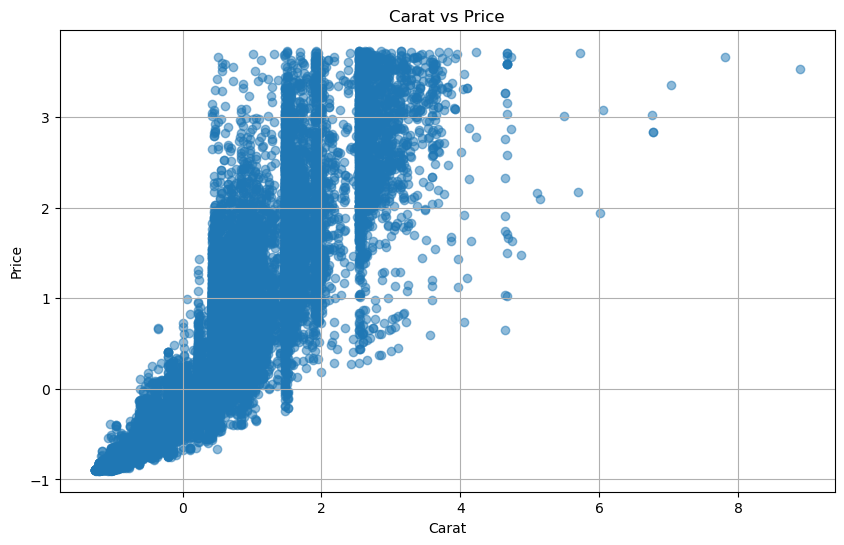

In [8]:
# TODO: display data in scatter plot

carat = x[:, 0]
price = x[:, 3]  

plt.figure(figsize=(10, 6))
plt.scatter(carat, price, alpha=0.5)
plt.title('Carat vs Price')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Task 8

Set up the design matrix and use your class to estimate $\theta$ on the dataset.
Note, that the design matrix does **not** need the vector of ones, since we standardized the dataset.

Plot the regression line defined by $\theta$.

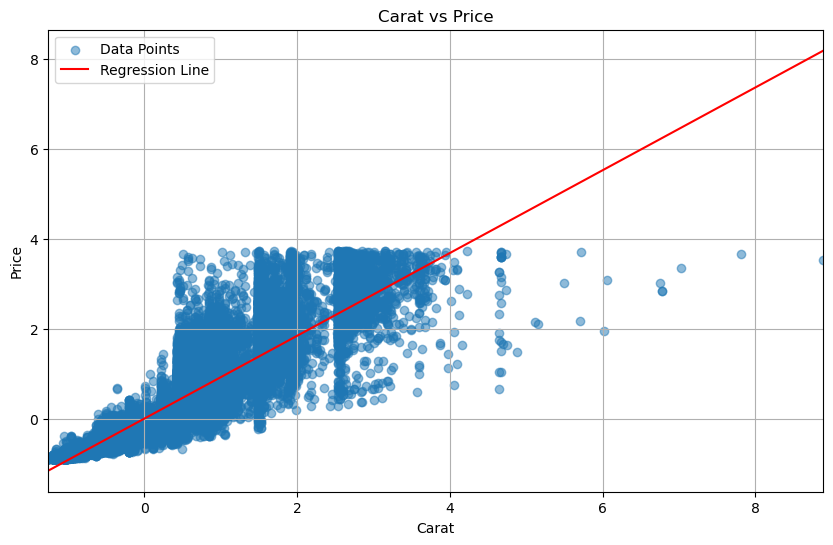

In [9]:
# TODO: build design matrix, y
design_matrix = x[:, 0:1]
y = x[:, 3]

# TODO: use Linear Regression
regressor = LinearRegressor(regularization_constant=0.1).fit_max_liklihood(design_matrix, y)


# TODO: plot data + regression line

# Assuming carat and price are already defined as numpy arrays
plt.figure(figsize=(10, 6))
plt.scatter(carat, price, alpha=0.5, label='Data Points')  # Plot the raw data points
plt.title('Carat vs Price')  # Title of the plot
plt.xlabel('Carat')  # X-axis label
plt.ylabel('Price')  # Y-axis label
plt.grid(True)  # Add a grid for easier visualization

# Adjust x_vals to cover the entire range of carat values
x_vals = np.linspace(np.min(carat), np.max(carat), 500).reshape(-1, 1)  # Ensure full coverage
y_vals = regressor.predict(x_vals)  # Predicted prices

# Plot the regression line
plt.plot(x_vals, y_vals, color='red', label='Regression Line')  # Add the regression line

# Adjust the x-axis limits if needed
plt.xlim([np.min(carat), np.max(carat)])  # Set x-axis limits to match the range of carat values

plt.legend()
plt.show()
# assertions
assert design_matrix.shape == (53940, 1)
assert np.isclose(regressor.theta[0], 0.9215913)

### Task 9

You can find an implementation of this method in the python module [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Use it and compare your result for the estimation of $\theta$.

**Important:** scikit learn needs the design matrix as a $m \times n$ matrix (datapoints as rows).

In [10]:
from sklearn.linear_model import LinearRegression

# TODO: use scikit learn to estimate theta

reg = LinearRegression().fit(design_matrix, y)

# TODO: compare results

assert np.isclose(regressor.theta[0], reg.coef_)

### Task 10

Now predict the `price` from the variables `carat`, `depth`, `table`, `x`, `y`, `z`.

- Estimate $\theta$ with your class
- Estimate $\theta$ with scikit learn
- Compare both estimations

In [11]:
# TODO: build X, Y
X = x[:, [0, 1, 2, 4, 5, 6]]
Y = x[:, 3]

regressor = LinearRegressor(regularization_constant=0.1).fit_max_liklihood(X, Y)
reg = LinearRegression().fit(X, Y)
# TODO: estimate theta
my_theta = regressor.theta

# TODO: estimate theta using scikit-learn + compare
sklearn_theta = reg.coef_

# assertions
assert np.allclose(sklearn_theta, my_theta)
assert np.allclose(my_theta, np.array([1.26970978, -0.07295331, -0.05737995, -0.36994281, 0.01898718, 0.00736359]))